<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Modelos ARIMA - Como Determinar os Valores de p, d e q</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br

O que significam p, d e q no modelo ARIMA?

Um modelo ARIMA requer 3 parâmetros:

- param q: (int) Ordem do modelo MA.
- param p: (int) Ordem do modelo de AR.
- param d: (int) Número de vezes que os dados precisam ser diferenciados.

Neste modelo vamos determinar o valor desses 3 parâmetros.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import pmdarima
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pandas.plotting import autocorrelation_plot

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

pandas      1.0.5
statsmodels 0.11.1
numpy       1.16.6
pmdarima    1.6.1
matplotlib  3.3.0
sklearn     0.23.1
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [3]:
# Carrega os dados
dataframe = pd.read_csv("Arrecadacao_icms.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [4]:
# Dados
dataframe.head()

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702


In [5]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['Arrecadacao']

In [6]:
# Random seed 
np.random.seed(7)

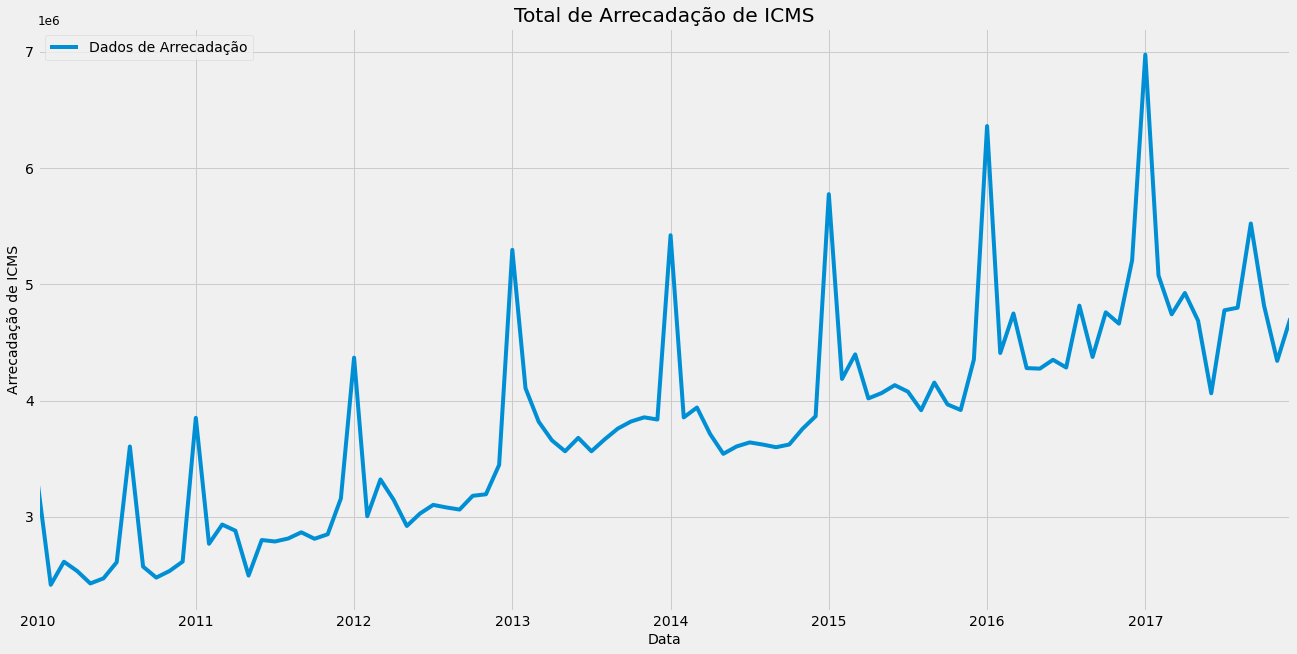

In [7]:
# Plot
target.plot(title = 'Total de Arrecadação de ICMS', fontsize = 14, label = 'Dados de Arrecadação') 
plt.xlabel("Data") 
plt.ylabel("Arrecadação de ICMS") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

72 24


Para Modelos ARIMA, devemos remover a tendência. Vamos fazer isso.

In [9]:
# Aplicando transformação de log
treino_log = np.log(treino) 

In [10]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
teste_log = np.log(teste)

Vamos testar a estacionaridade da série.

In [11]:
# Teste ADF
resultado = adfuller(dataframe['Arrecadacao'])
print('Estatística ADF: %f' % resultado[0])
print('Valor-p: %f' % resultado[1])

Estatística ADF: -3.891400
Valor-p: 0.002099


O valor-p é menor que 0.05, portanto, não precisamos calcular o valor de 'd'. Ou seja, d = 0 no Modelo ARIMA.

Você rejeitará a hipótese nula e poderá inferir que a série temporal É ESTACIONÁRIA.

In [12]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [13]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

## Determinando o Valor do Parâmetro d para o Modelo ARIMA

O Teste ADF indicou d = 0 e o Teste KPSS indicou d = 1.

Vamos escolher d = 1. A escolha é sua meu caro(a) Cientista de Dados.

Já temos o I de ARIMA, o parâmetro d. Agora vamos encontrar o termo AR, com o parâmetro p.

## Já temos o I de ARIMA (p, d, q), o parâmetro d = 1

## Determinando o Valor do Parâmetro p para o Modelo ARIMA

A próxima etapa é identificar se o modelo precisa de termos AR. Você pode descobrir o número necessário de termos AR, inspecionando o gráfico PACF (Partial Autocorrelation). Mas o que é PACF?

A autocorrelação parcial pode ser imaginada como a correlação entre a série e seu atraso, após excluir as contribuições dos atrasos intermediários. Portanto, o PACF meio que transmite a correlação pura entre um atraso e a série. Dessa forma, você saberá se esse atraso é necessário no termo AR ou não.

Qualquer autocorrelação em uma série estacionarizada pode ser retificada adicionando termos AR suficientes. Portanto, inicialmente consideramos a ordem do termo AR igual a tantas defasagens que ultrapassam o limite de significância no gráfico PACF.

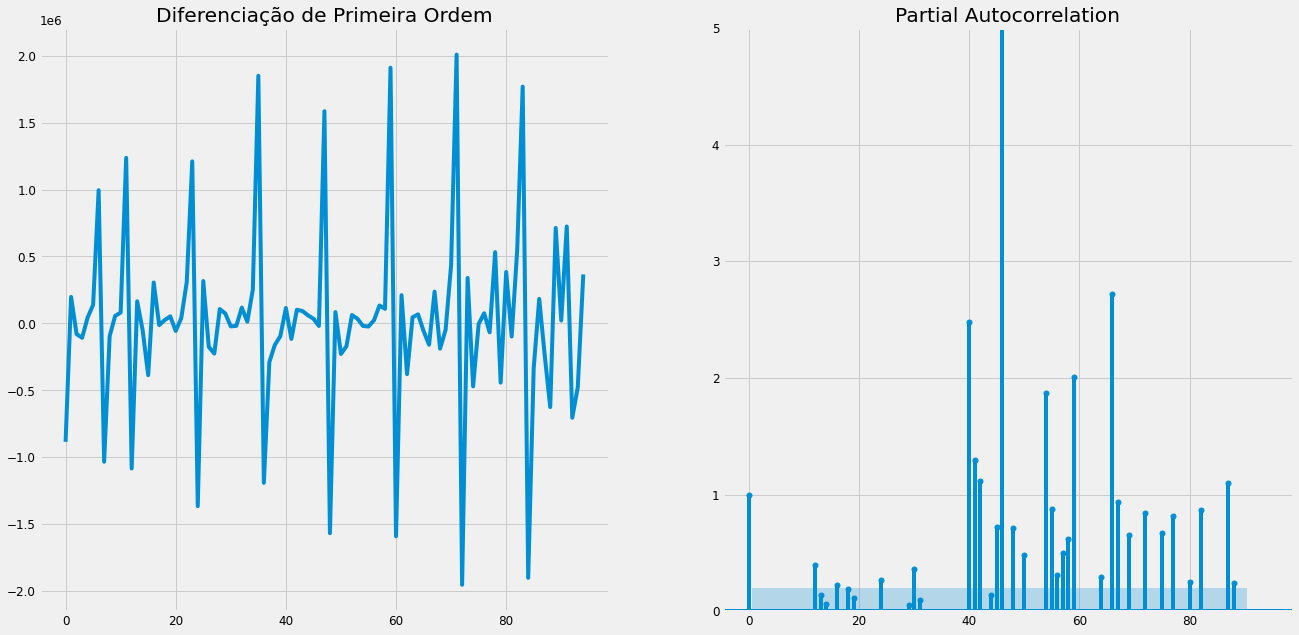

In [14]:
# Gráfico PACF
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(np.diff(target.values)); axes[0].set_title('Diferenciação de Primeira Ordem')
axes[1].set(ylim = (0,5))
plot_pacf(np.diff(target.values), lags = 90, ax = axes[1])
plt.show()

Humm... O gráfico PACF não está ajudando muito. Tudo bem, tenho mais uma ferramenta aqui na manga. Sabe como é. Quanto mais ferramentas você conhece, mais problemas você é capaz de resolver. Já dizia aquele instrutor da DSA.

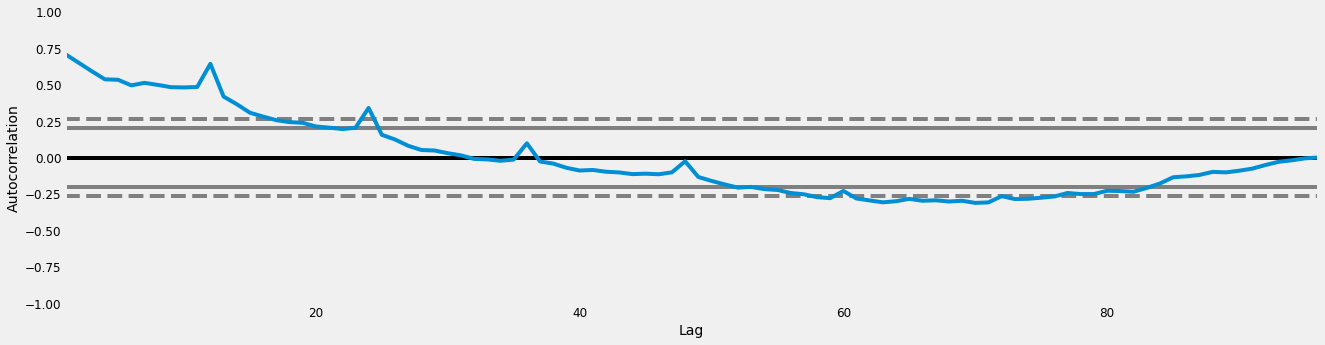

In [15]:
# Autocorrelation Plot
plt.figure(figsize = [20,5]) 
autocorrelation_plot(target)
plt.show()

Você pode observar que o atraso (lag) 1 é bastante significativo, pois está bem acima da linha de significância. O atraso 2 também é significativo, conseguindo ultrapassar o limite de significância. Mas vou ser conservador e definir o valor do parâmetro p igual a 1. Já temos o termo AR. Falta um. 

## Já temos o AR e I de ARIMA (p, d, q), os parâmetros p = 1, d = 1

## Determinando o Valor do Parâmetro q para o Modelo ARIMA

Assim como observamos o gráfico PACF para o número de termos AR, você pode observar para o gráfico ACF para o número de termos MA. Um termo MA é tecnicamente o erro da previsão atrasada.

O ACF informa quantos termos MA são necessários para remover qualquer autocorrelação na série estacionarizada.

Vamos ver o gráfico de autocorrelação das séries diferenciadas.

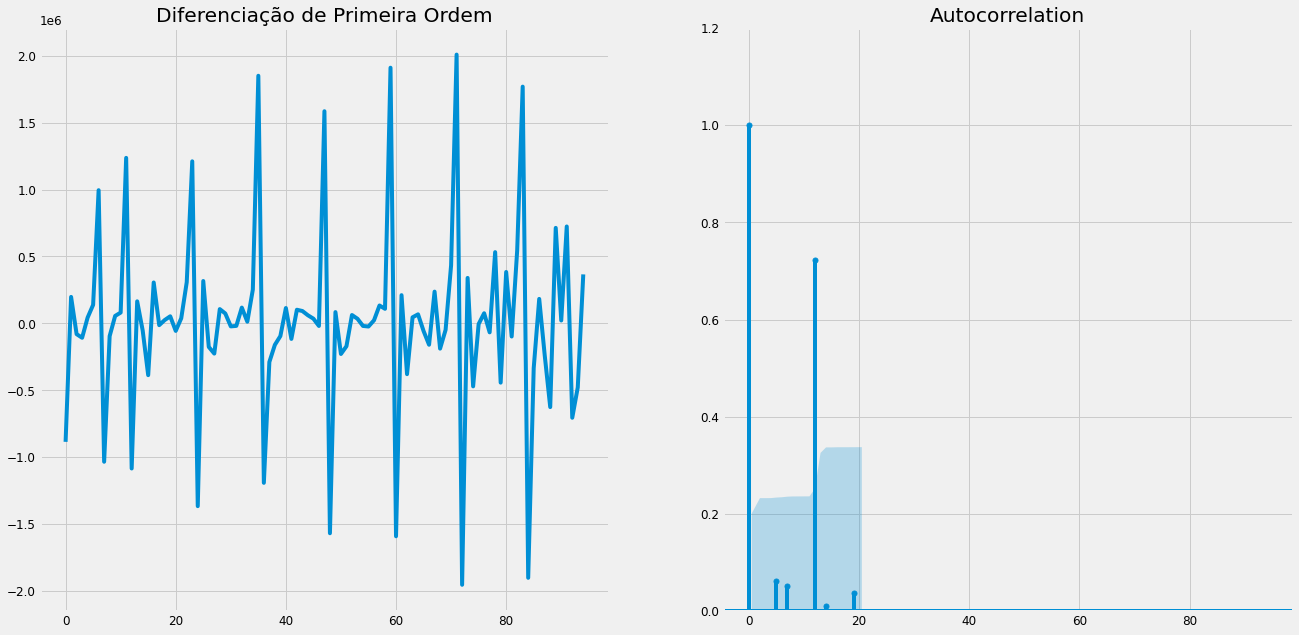

In [16]:
# Gráfico ACF
fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(np.diff(target.values)); axes[0].set_title('Diferenciação de Primeira Ordem')
axes[1].set(ylim = (0,1.2))
plot_acf(np.diff(target.values), ax = axes[1])
plt.show()

O gráfico de autocorrelação indica que temos pelo menos um valor acima do limite de 0.2. Ou seja, q = 1 é o mínimo que deveríamos testar, embora o q = 2 seja uma opção. Você pode testar as duas opções se desejar, mas eu vou escolher q = 1.

## Já temos todos os parâmetros de ARIMA (p, d, q) (1, 1, 1), p = 1, d = 1, q = 1

Para quem gosta de regras, aqui está uma lista completa:

https://people.duke.edu/~rnau/arimrule.htm

Já temos os 3 parâmetros para o Modelo ARIMA (p, d, q) - order(1, 1, 1).

Mas espere. Nós tínhamos criado o Modelo ARIMA na Aula 13 com order (2, 1, 0). Ok, vamos alterar o modelo e ver o que acontece. 

Vamos preparar os dados para o modelo.

Vamos criar nosso Modelo ARIMA.

## Forecasting - Modelagem Preditiva Para Séries Temporais

### Modelo ARIMA

Vamos criar nosso primeiro Modelo ARIMA. Para começar vamos criar um modelo simples, treiná-los e fazer previsões e nas aulas seguintes vamos explorar os detalhes de Modelos ARIMA, como interpretar o resultado, os resíduos e melhorar o modelo.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

In [17]:
# Cria o Modelo ARIMA com order (1, 1, 1)
#modelo_AR = ARIMA(df_treino_log, order = (0, 1, 0), freq = 'H')
modelo_AR = ARIMA(treino_log, order = (1, 1, 1))

C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [22]:
# Treinamento
modelo_v1 = modelo_AR.fit(disp = -1)  

Agora vamos fazer previsões com o modelo treinado.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html

Vamos fazer previsões com o modelo.

In [23]:
# Sumário do Modelo - Nas próximas aulas vamos interpretar esse sumário do modelo
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Arrecadacao   No. Observations:                   71
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  46.921
Method:                       css-mle   S.D. of innovations              0.122
Date:                Sat, 22 Aug 2020   AIC                            -85.842
Time:                        19:13:30   BIC                            -76.791
Sample:                    02-01-2010   HQIC                           -82.242
                         - 12-01-2015                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0073      0.001      8.382      0.000       0.006       0.009
ar.L1.D.Arrecadacao     0.2167      0.120      1.807      0.071      -0.018       0.452
ma.L1.D.Arrecadacao    -0.9999      0.047    -21.496      0.000      -1.091      -0.909
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.6153           +0.0000j            4.6153            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [24]:
# Forecast
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
fc, se, conf = modelo_v1.forecast(len(teste_log), alpha = 0.05) 

In [25]:
# Previsões
#fc

In [26]:
# Erro
#se

In [27]:
# Coeficientes
#conf

In [28]:
# Precisamos criar um dataframe para criar o Plot
fc_series = pd.Series(fc, index = teste_log.index)
limite_inferior = pd.Series(conf[:, 0], index = teste_log.index)
limite_superior = pd.Series(conf[:, 1], index = teste_log.index)

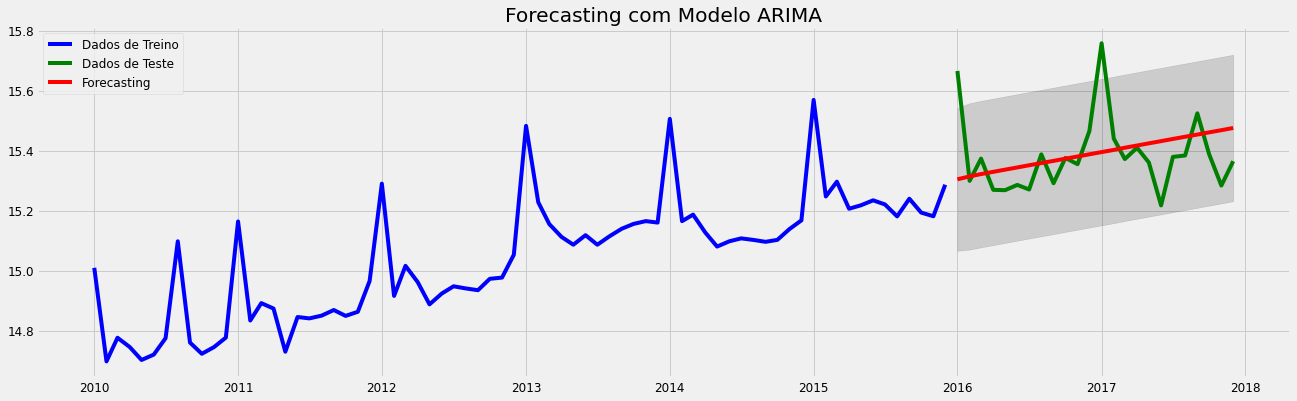

In [29]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino_log, label = 'Dados de Treino', color = 'blue')
plt.plot(teste_log, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting', color = 'red')
plt.fill_between(limite_inferior.index, limite_inferior, limite_superior, color = 'k', alpha = .15)
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

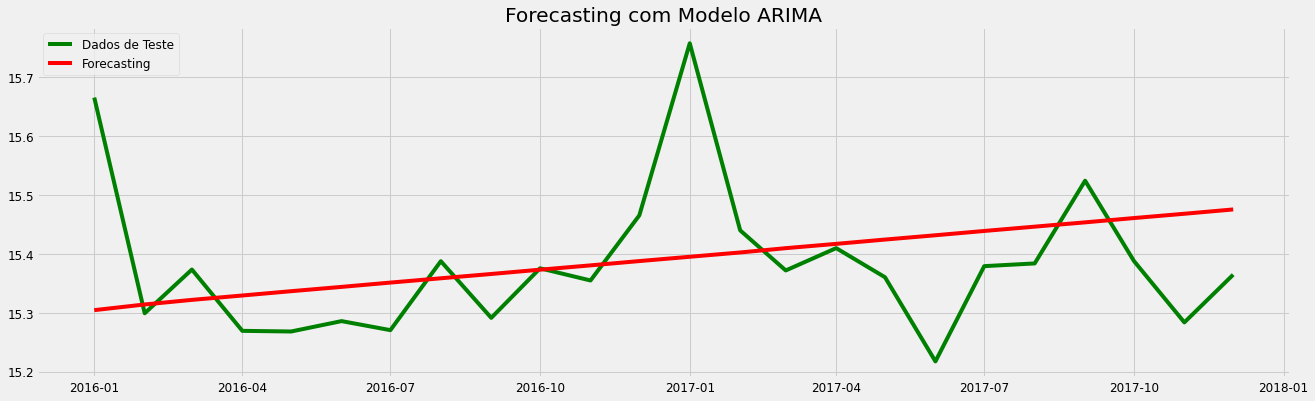

In [30]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste_log, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [31]:
# Define valor real e valor previsto
y_true = teste_log
y_pred = fc_series

In [32]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.1312389800970525


In [33]:
# Define valor real e valor previsto invertendo o LOG
y_true = np.exp(teste_log)
y_pred = np.exp(fc_series)

In [34]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

694827.8110726376


Opa! Reduzimos um pouco o erro do nosso modelo. 

Reduzimos:


Reduzimos de 805471.0878 (naive) para 750397.7727 (previsoes_v2 modelo 12) e aumentou para 767631.9506 (modelo 13).

_ modelo  11____modelo 12____modelo 13____modelo 14

_805471.0878__750397.7727____767631.9506____694827.8110

Podemos usar até mesmo Cross Validation para isso. 

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim